In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Multi-Factor Models

## Implementing the CAPM in Python

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

2. Specify the risky asset and the time horizon:

In [4]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [5]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1257 rows of data.


4. Resample to monthly data and calculate simple returns:

In [8]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030
2014-06-30,0.039130,0.019058


5. Calculate beta using the covariance approach: 

In [11]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.6296083359501388

6. Prepare the input and estimate CAPM as a linear regression:

In [12]:
# separate target
y = X.pop('asset')

In [18]:
# add column of 1s to the array X
X = sm.add_constant(X)

In [20]:
# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.77
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           4.05e-07
Time:                        18:01:34   Log-Likelihood:                 75.313
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.009      1.950      0.0

### This is telling us (since the coefficient - called Jensen's alpha - is greater than zero at a 5 ish percent sig level) that the returns from the asset are abnormally high

... or it is telling us the CAPM is not correct (shock)

... or it is telling us both.

In [24]:
# Note: we can also use 
import statsmodels.formula.api as smf

asset=y
capm_model_formula = smf.ols(formula="asset~market", data=X).fit()

In [25]:
capm_model_formula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  asset   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.77
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           4.05e-07
Time:                        18:09:29   Log-Likelihood:                 75.313
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0178      0.009      1.950      0.056      -0.000       0.036
market         1.6296      0.285      5.724      0.000       1.060       2.200
==============================================================================
Omnibus:                        3.055   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.368
Skew:                           0.482   Prob(JB):                        0.306
Kurtosis:                       3.185   Cond. No.                         31.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### There's more...

#### Risk-free rate (13 Week Treasury Bill)

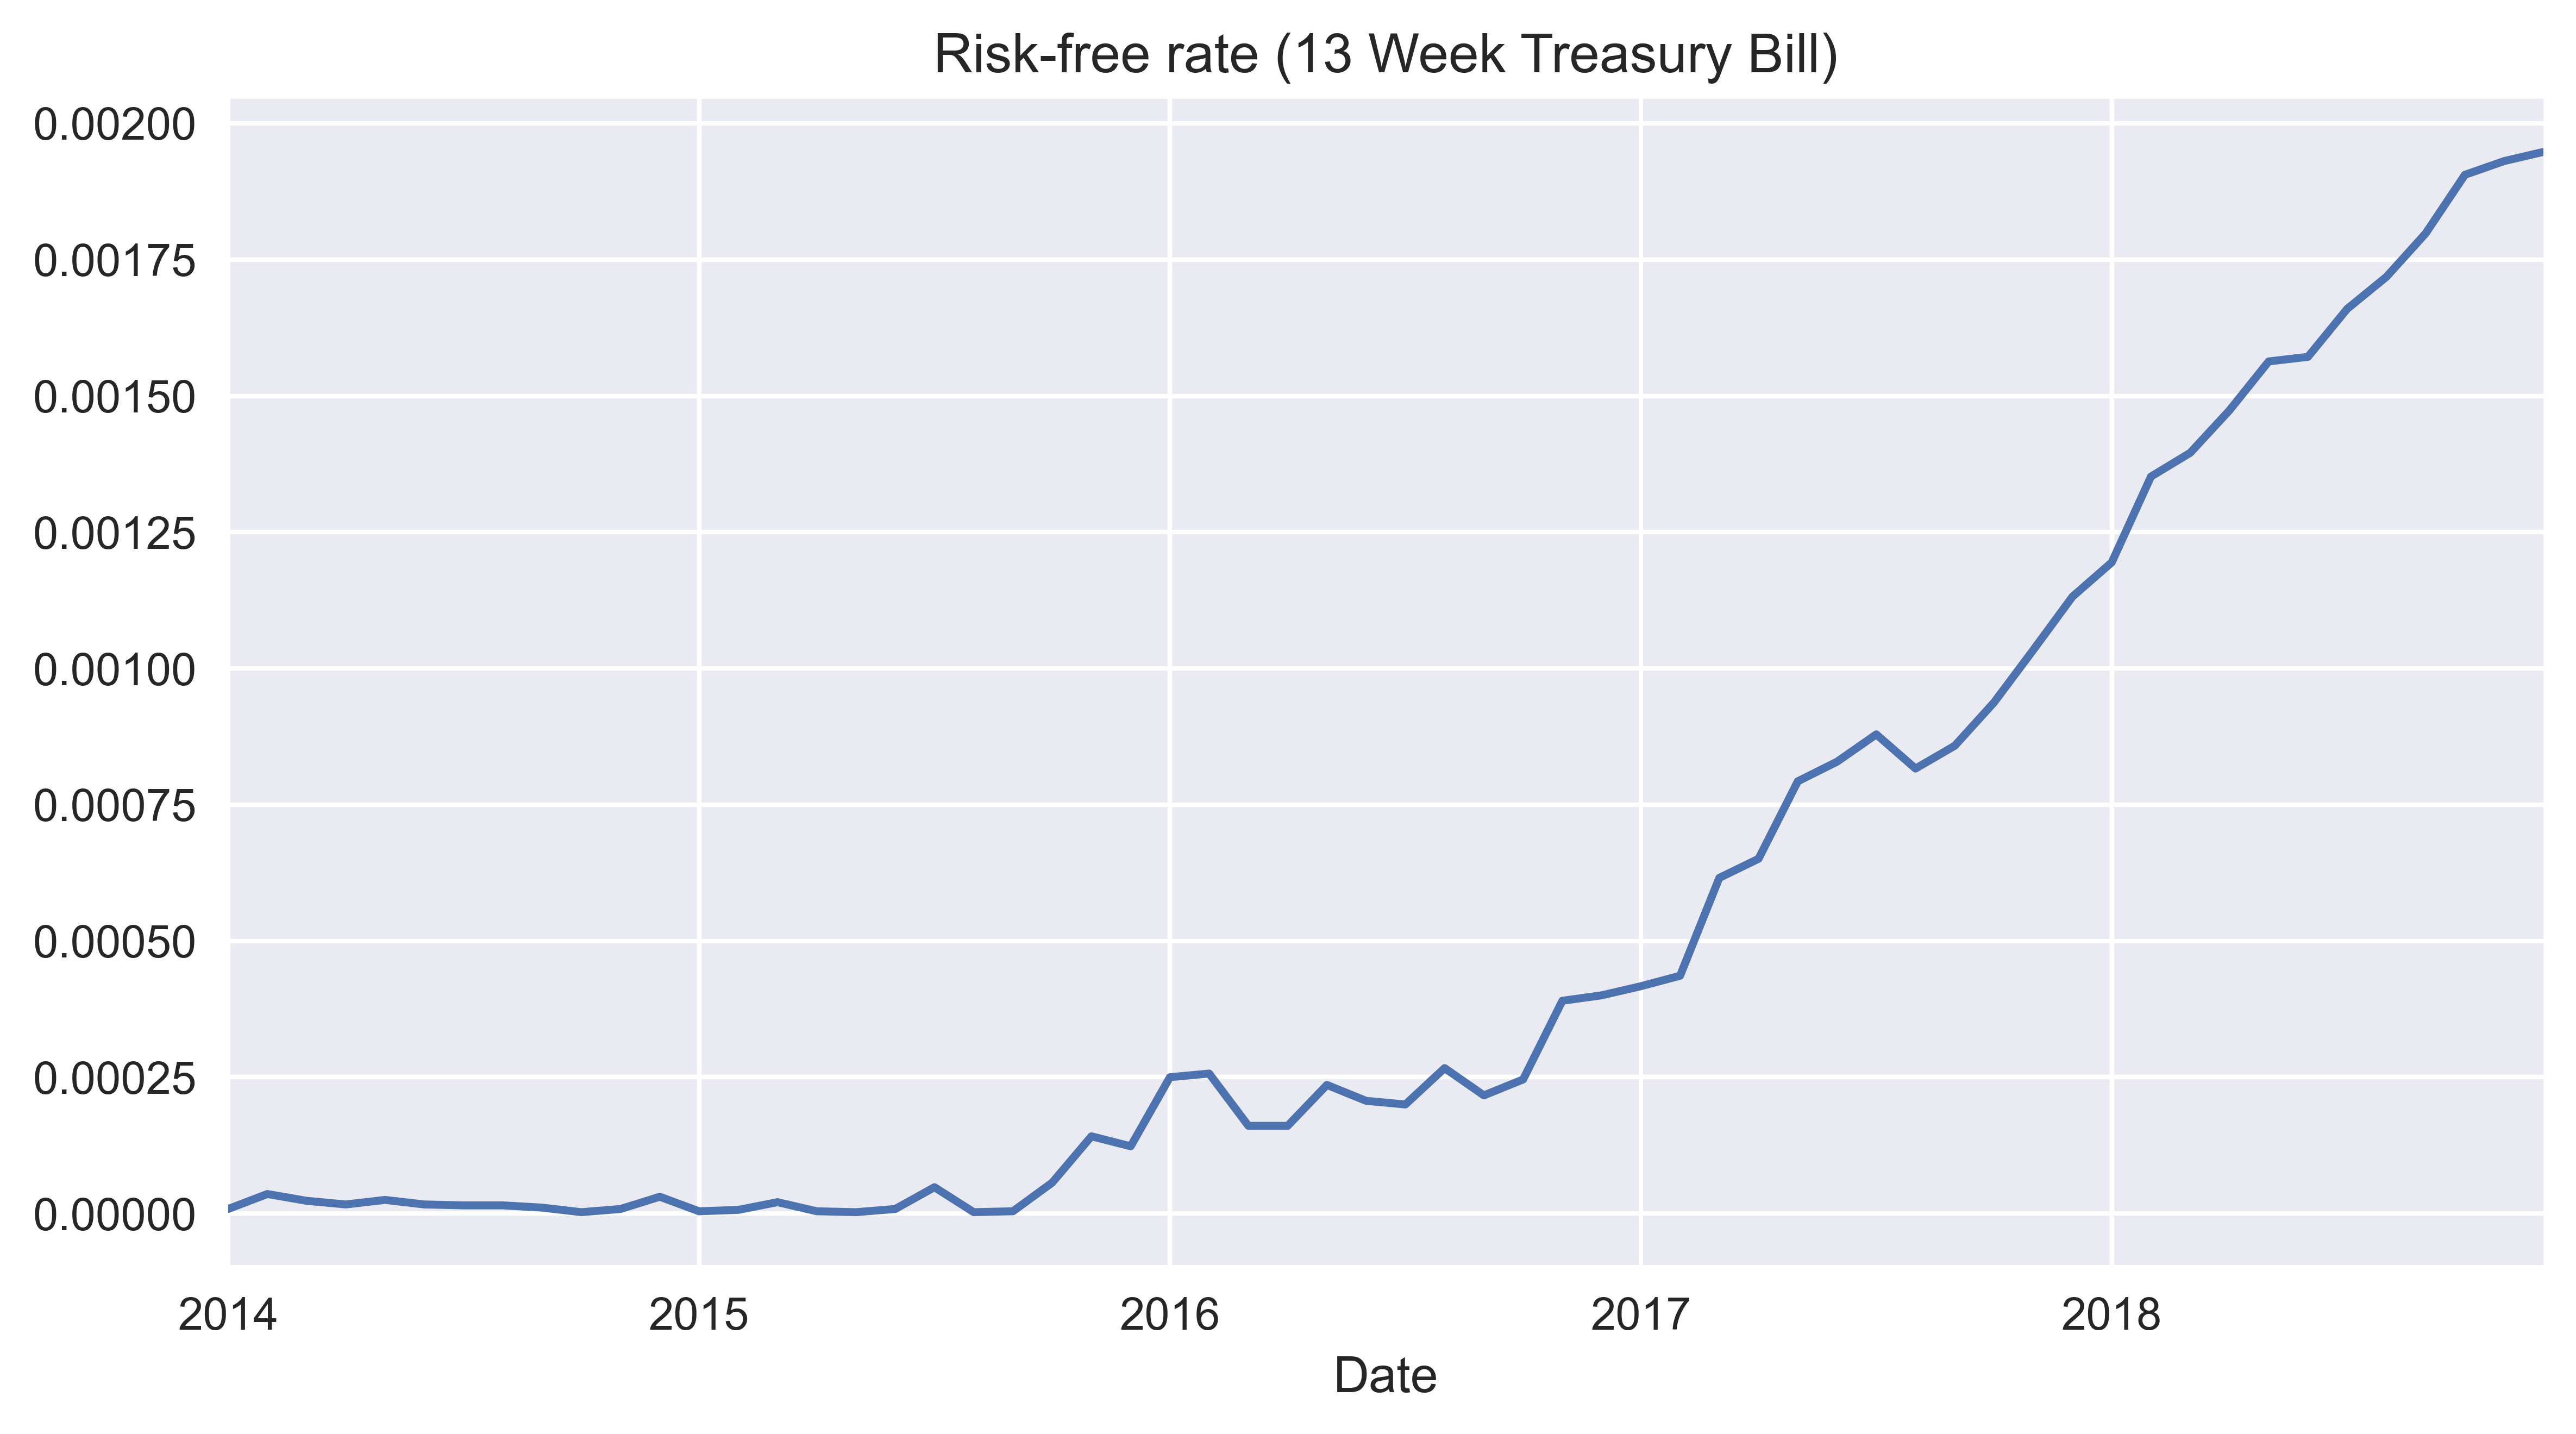

In [27]:
# period lenght in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im2.png')
plt.show()

#### Risk-free rate (3-Month Treasury Bill)

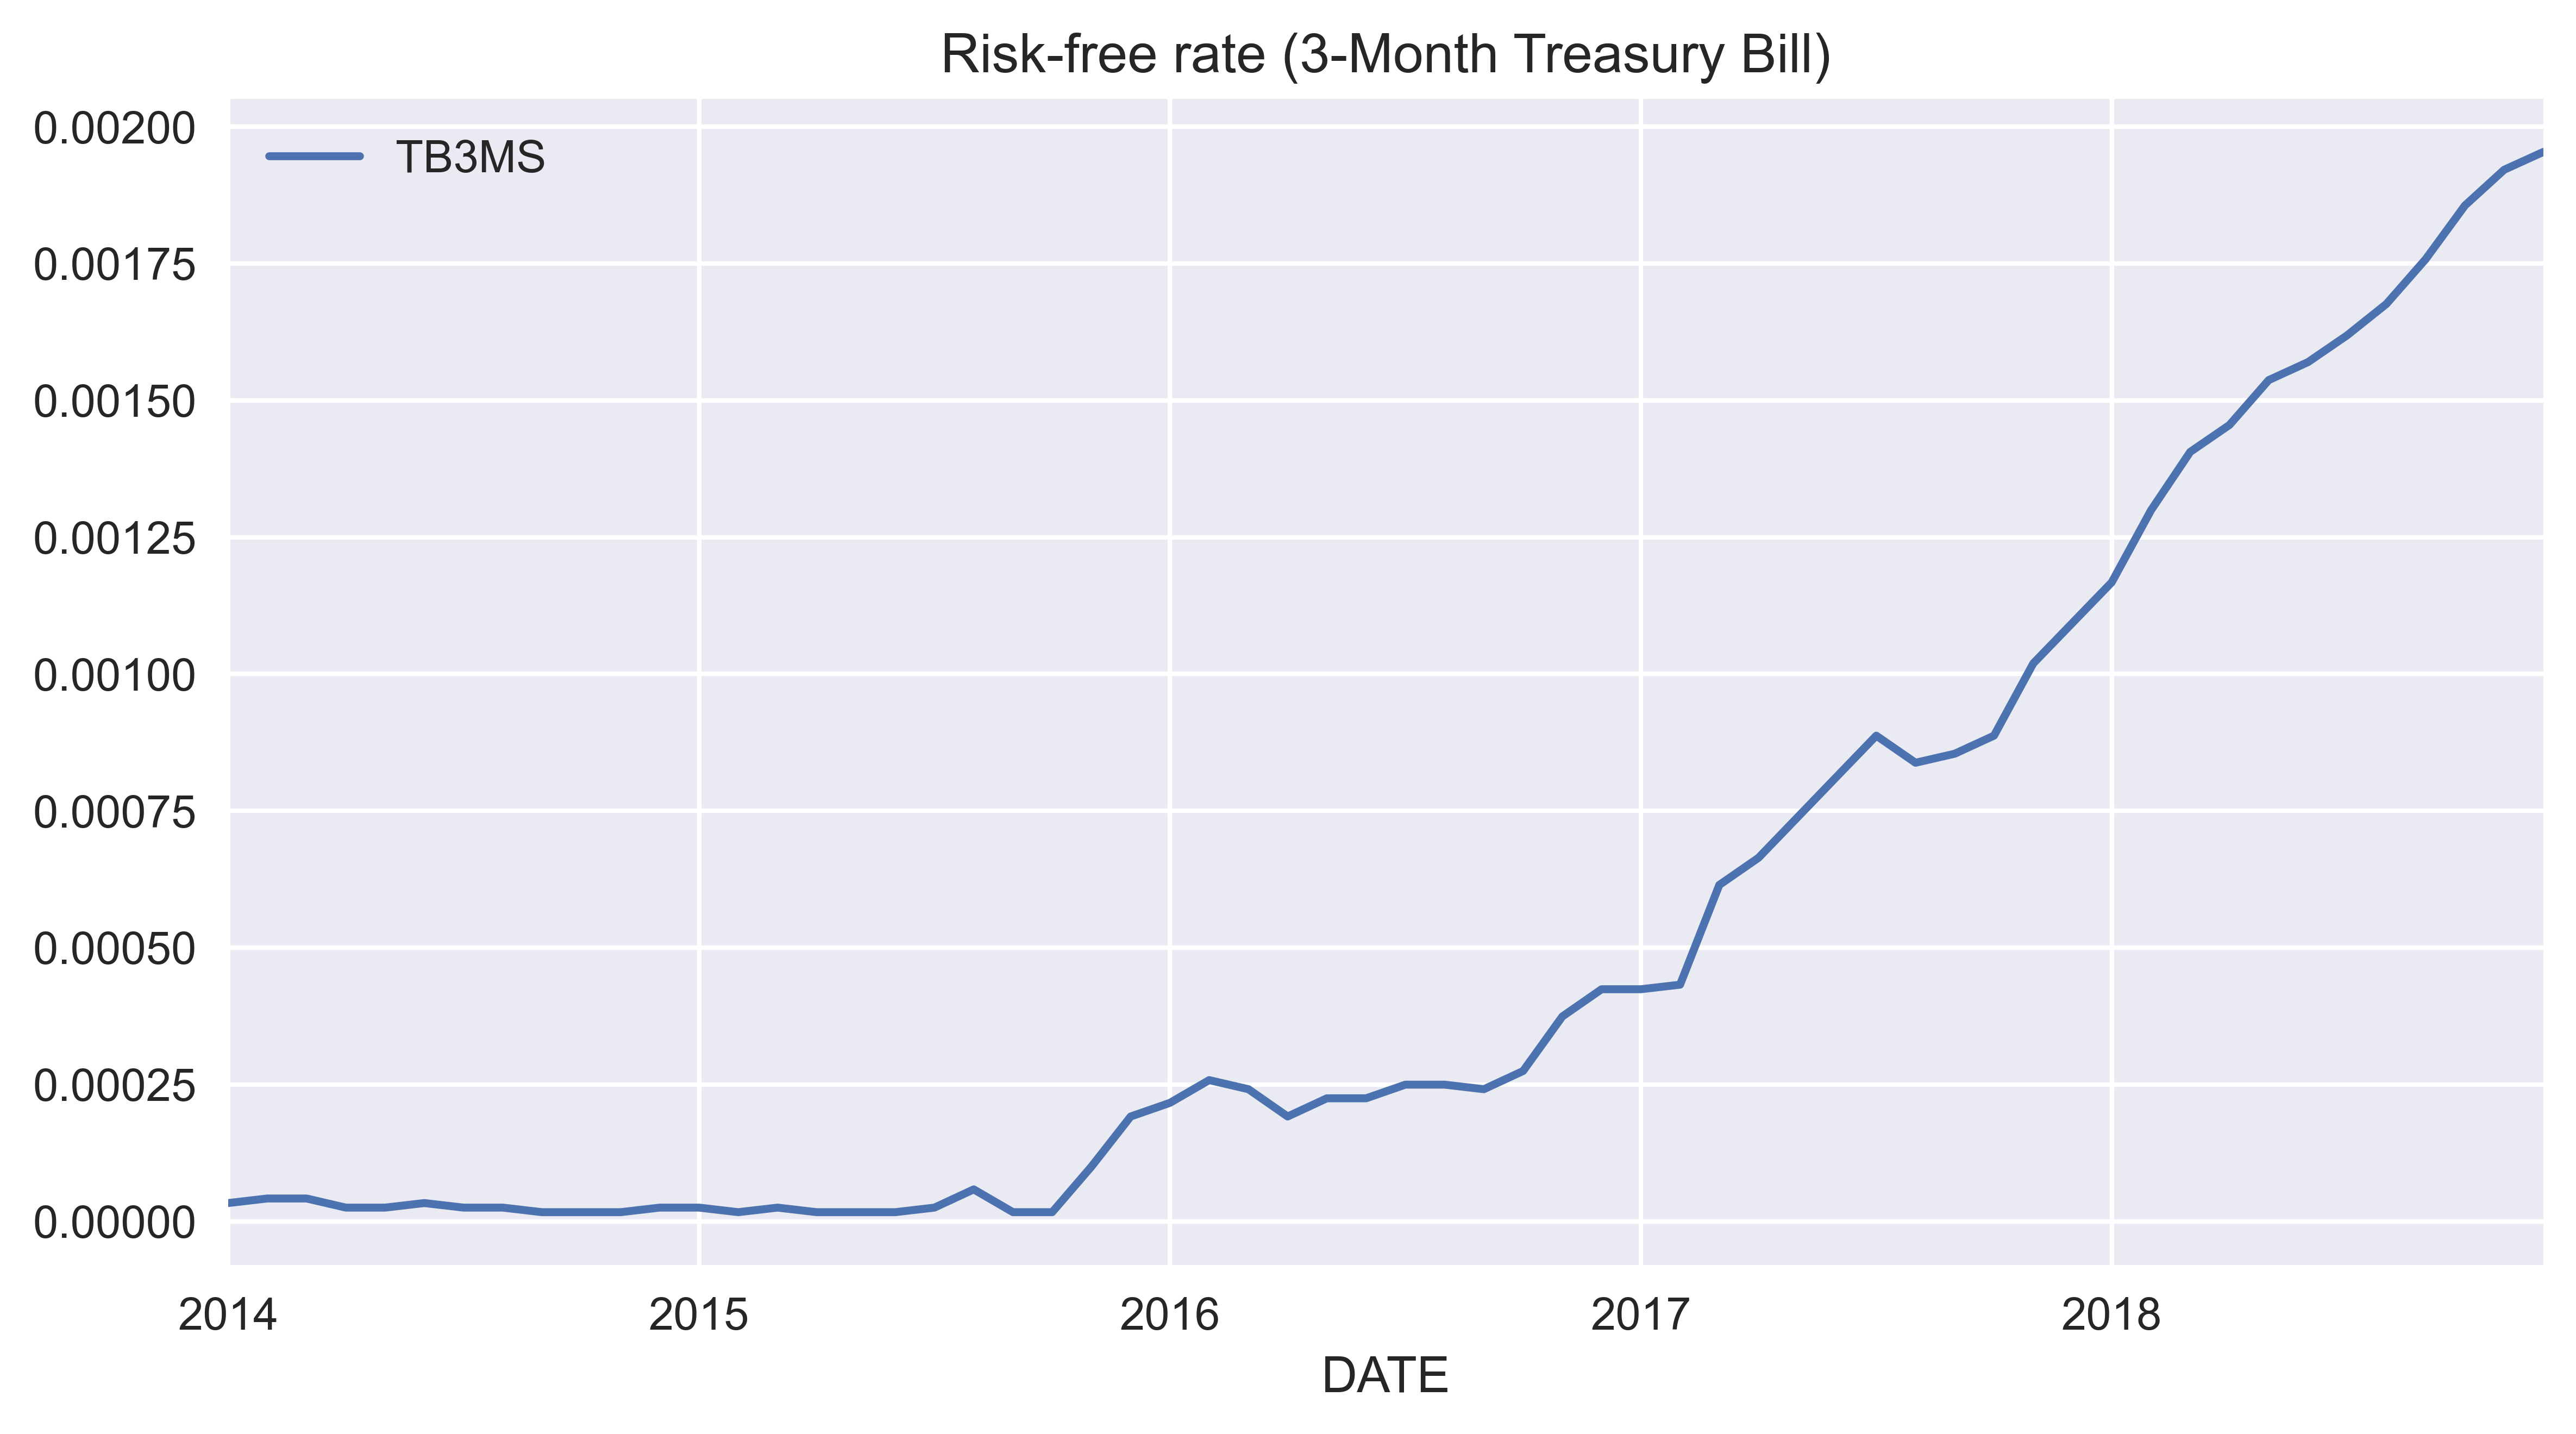

In [30]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im3.png')
plt.show()

### pandas data-reader is deprecated though...

## Implementing the Fama-French three-factor model in Python

### How to do it...

1. Import the libraries:

In [31]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

2. Download data from prof. French's website:

In [33]:
# download the zip file from Prof. French's website
# !wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip
# !unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip
# !rm F-F_Research_Data_Factors_CSV.zip

3. Define parameters:

In [34]:
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

4. Load data from the source CSV file and keep only the monthly data:

In [36]:
# load data from csv
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

In [40]:
len(factor_df)

1216

In [41]:
# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

In [42]:
start_of_annual

1121

In [44]:
# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

In [50]:
factor_df.tail()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
1116,201907,1.19,-2.07,0.14,0.19
1117,201908,-2.58,-2.41,-4.99,0.16
1118,201909,1.44,-0.90,6.71,0.18
1119,201910,2.06,0.25,-2.07,0.15
1120,201911,3.87,0.86,-1.88,0.12


5. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [51]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

C:\Users\Josep\anaconda3\envs\Stochastic_finance\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [54]:
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


6. Convert the values to numeric and divide by 100:

Turns numbers into floats and then errors = "coerce" changes anything silly into a NaN value. 

In [53]:
factor_df = factor_df.apply(pd.to_numeric, 
                            errors='coerce') \
                     .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


7. Download the prices of the risky asset:

In [63]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


8. Calculate monthly returns on the risky asset:

In [64]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

Date
2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

9. Merge the datasets and calculate excess returns:

In [67]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf
ff_data.head()

,mkt,smb,hml,rf,rtn,excess_rtn
date,,,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0,0.144922,0.144922
2014-02,0.0465,0.0034,-0.0040,0.0,0.094135,0.094135
2014-03,0.0043,-0.0189,0.0509,0.0,-0.120070,-0.120070
2014-04,-0.0019,-0.0424,0.0114,0.0,-0.007636,-0.007636
2014-05,0.0206,-0.0186,-0.0027,0.0,0.058883,0.058883


10. Estimate the three-factor model:

In [69]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()

# print results 
ff_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             excess_rtn   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5.175
Date:                Sun, 06 Dec 2020   Prob (F-statistic):            0.00316
Time:                        18:39:14   Log-Likelihood:                 88.392
No. Observations:                  60   AIC:                            -168.8
Df Residuals:                      56   BIC:                            -160.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.373      0.175      -0.005       0.026
mkt            0.5138      0.237      2.166      0.035       0.039       0.989
smb           -0.1618      0.301     -0.538      0.593      -0.765       0.441
hml           -0.9604      0.312     -3.074      0.003      -1.586      -0.335
==============================================================================
Omnibus:                        0.008   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.150
Skew:                          -0.006   Prob(JB):                        0.928
Kurtosis:                       2.755   Cond. No.                         44.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### SMB factor appears not to be significant at all!

We are regressing Fama-French coeffs onto the facebook price data. 

This tells us:
   1. Intercept is not significant (good) 
   2. Facebook is half as risky as the market ?? Not really, but given other factors that is the regression coeff.
   3. SMB is insignificant i.e. Facebook is not large *or* small (surely not).
   4. Facebook is not a value stock, but a growth stock (that is reasonable).

Let's try dropping the factor of size

In [83]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt', 
                   data=ff_data).fit()

# print results 
ff_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             excess_rtn   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     4.763
Date:                Sun, 06 Dec 2020   Prob (F-statistic):             0.0331
Time:                        18:56:09   Log-Likelihood:                 83.419
No. Observations:                  60   AIC:                            -162.8
Df Residuals:                      58   BIC:                            -158.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0130      0.008      1.606      0.114      -0.003       0.029
mkt            0.5312      0.243      2.182      0.033       0.044       1.018
==============================================================================
Omnibus:                        0.745   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.344
Skew:                          -0.172   Prob(JB):                        0.842
Kurtosis:                       3.137   Cond. No.                         30.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### There's more...

1. Import the libraries:

In [74]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

2. Print available datasets (here only first 5):

In [75]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

3. Download the selected dataset:

In [76]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [77]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

4. Inspect the description of the dataset

In [78]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202010 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (82 rows x 4 cols)
  1 : Annual Factors: January-December (6 rows x 4 cols)


5. View the monthly dataset:

In [80]:
ff_dict[0].head().append(ff_dict[0].tail())

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.87,-2.02,0.00
2014-02,4.65,0.31,-0.37,0.00
2014-03,0.43,-1.85,4.91,0.00
2014-04,-0.19,-4.21,1.11,0.00
2014-05,2.06,-1.91,-0.12,0.00
2020-06,2.46,2.70,-2.22,0.01
2020-07,5.77,-2.18,-1.31,0.01
2020-08,7.63,-0.26,-2.95,0.01
2020-09,-3.63,0.06,-2.56,0.01


## Implementing the rolling three-factor model on a portfolio of assets

### How to do it...

1. Import the libraries:

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [2]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

3. Download the factor related data:

In [3]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

4. Download the prices of risky assets from Yahoo Finance:

In [4]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2265 rows of data.


5. Calculate the monthly returns on the risky assets:

In [5]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

6. Calculate the portfolio returns:

In [6]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
2010-01,-0.088583,-0.067722,-0.145226,-0.075448,-0.094245
2010-02,0.065354,-0.055897,-0.005910,0.022092,0.006410
2010-03,0.148643,0.146706,0.076519,0.021614,0.098371
2010-04,0.110921,0.009796,-0.073027,0.042746,0.022609
2010-05,-0.016025,-0.084902,-0.076221,-0.151553,-0.082175


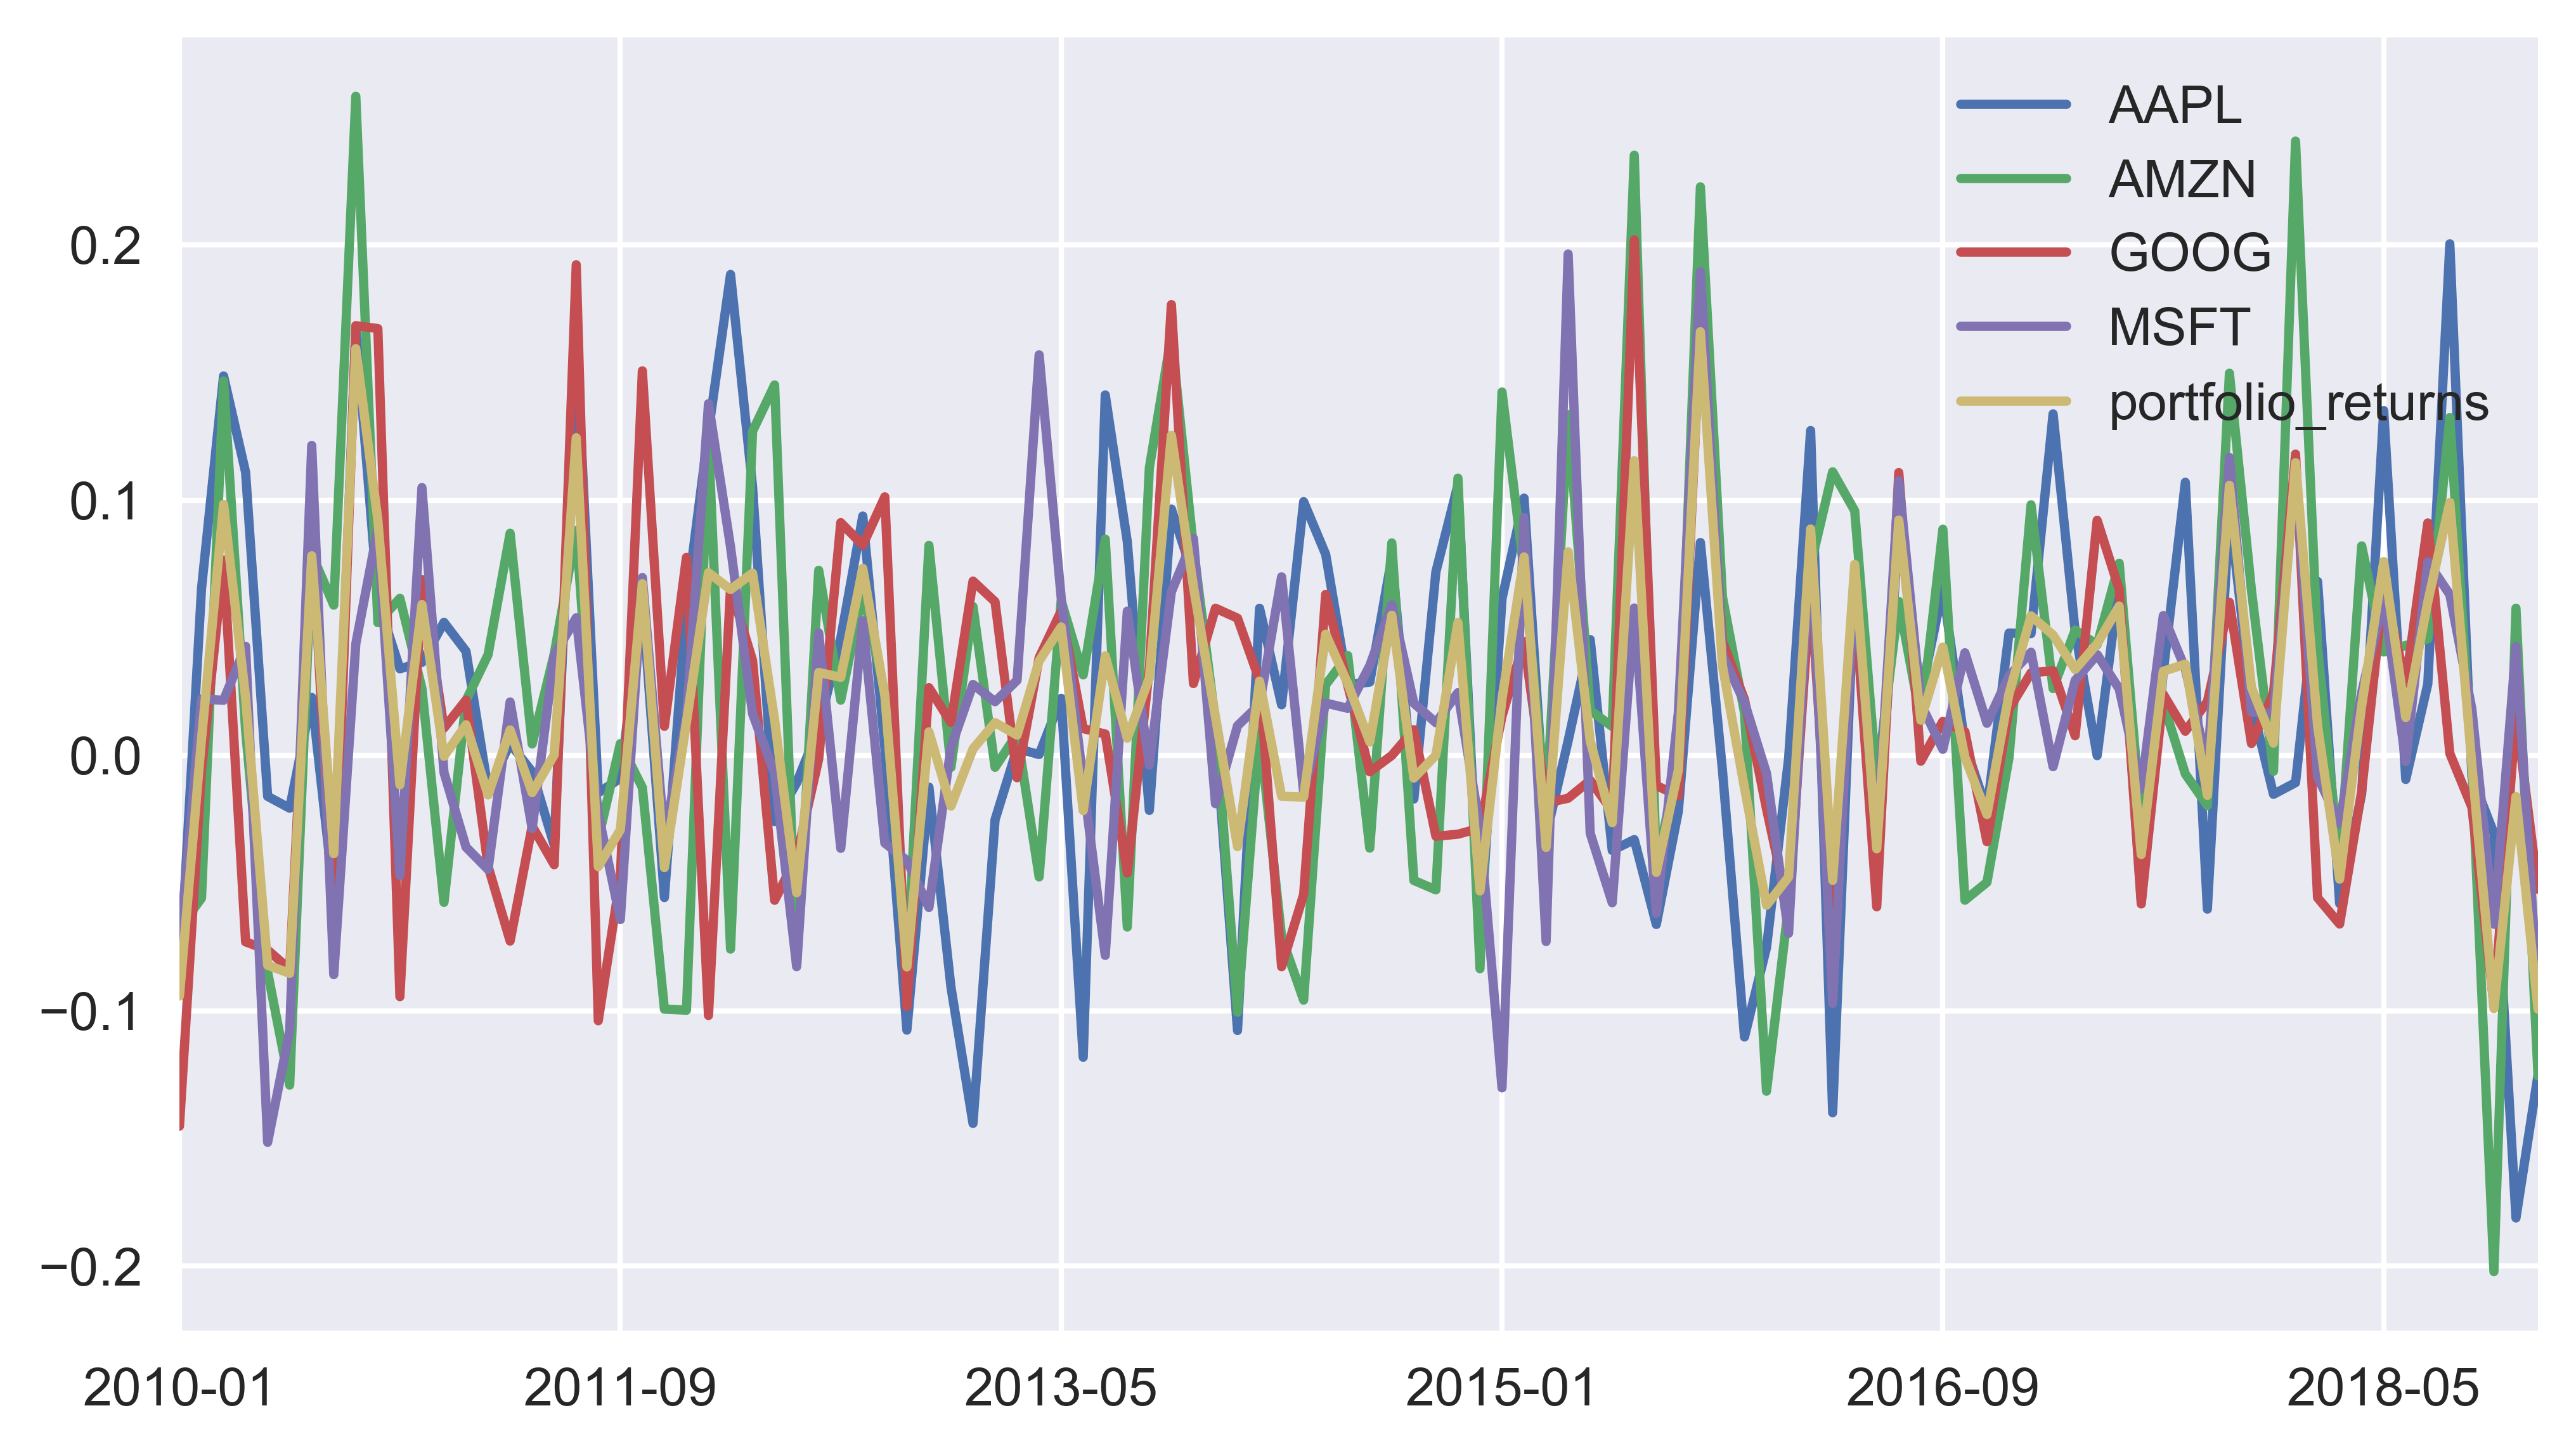

In [10]:
asset_df.plot()

7. Merge the datasets:

In [11]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [12]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
2010-01,-0.094245,-0.0336,0.0038,0.0030,0.0000,-0.094245
2010-02,0.006410,0.0340,0.0121,0.0316,0.0000,0.006410
2010-03,0.098371,0.0631,0.0143,0.0211,0.0001,0.098271
2010-04,0.022609,0.0200,0.0497,0.0281,0.0001,0.022509
2010-05,-0.082175,-0.0789,0.0005,-0.0238,0.0001,-0.082275


8. Define a function for the rolling n-factor model

In [15]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

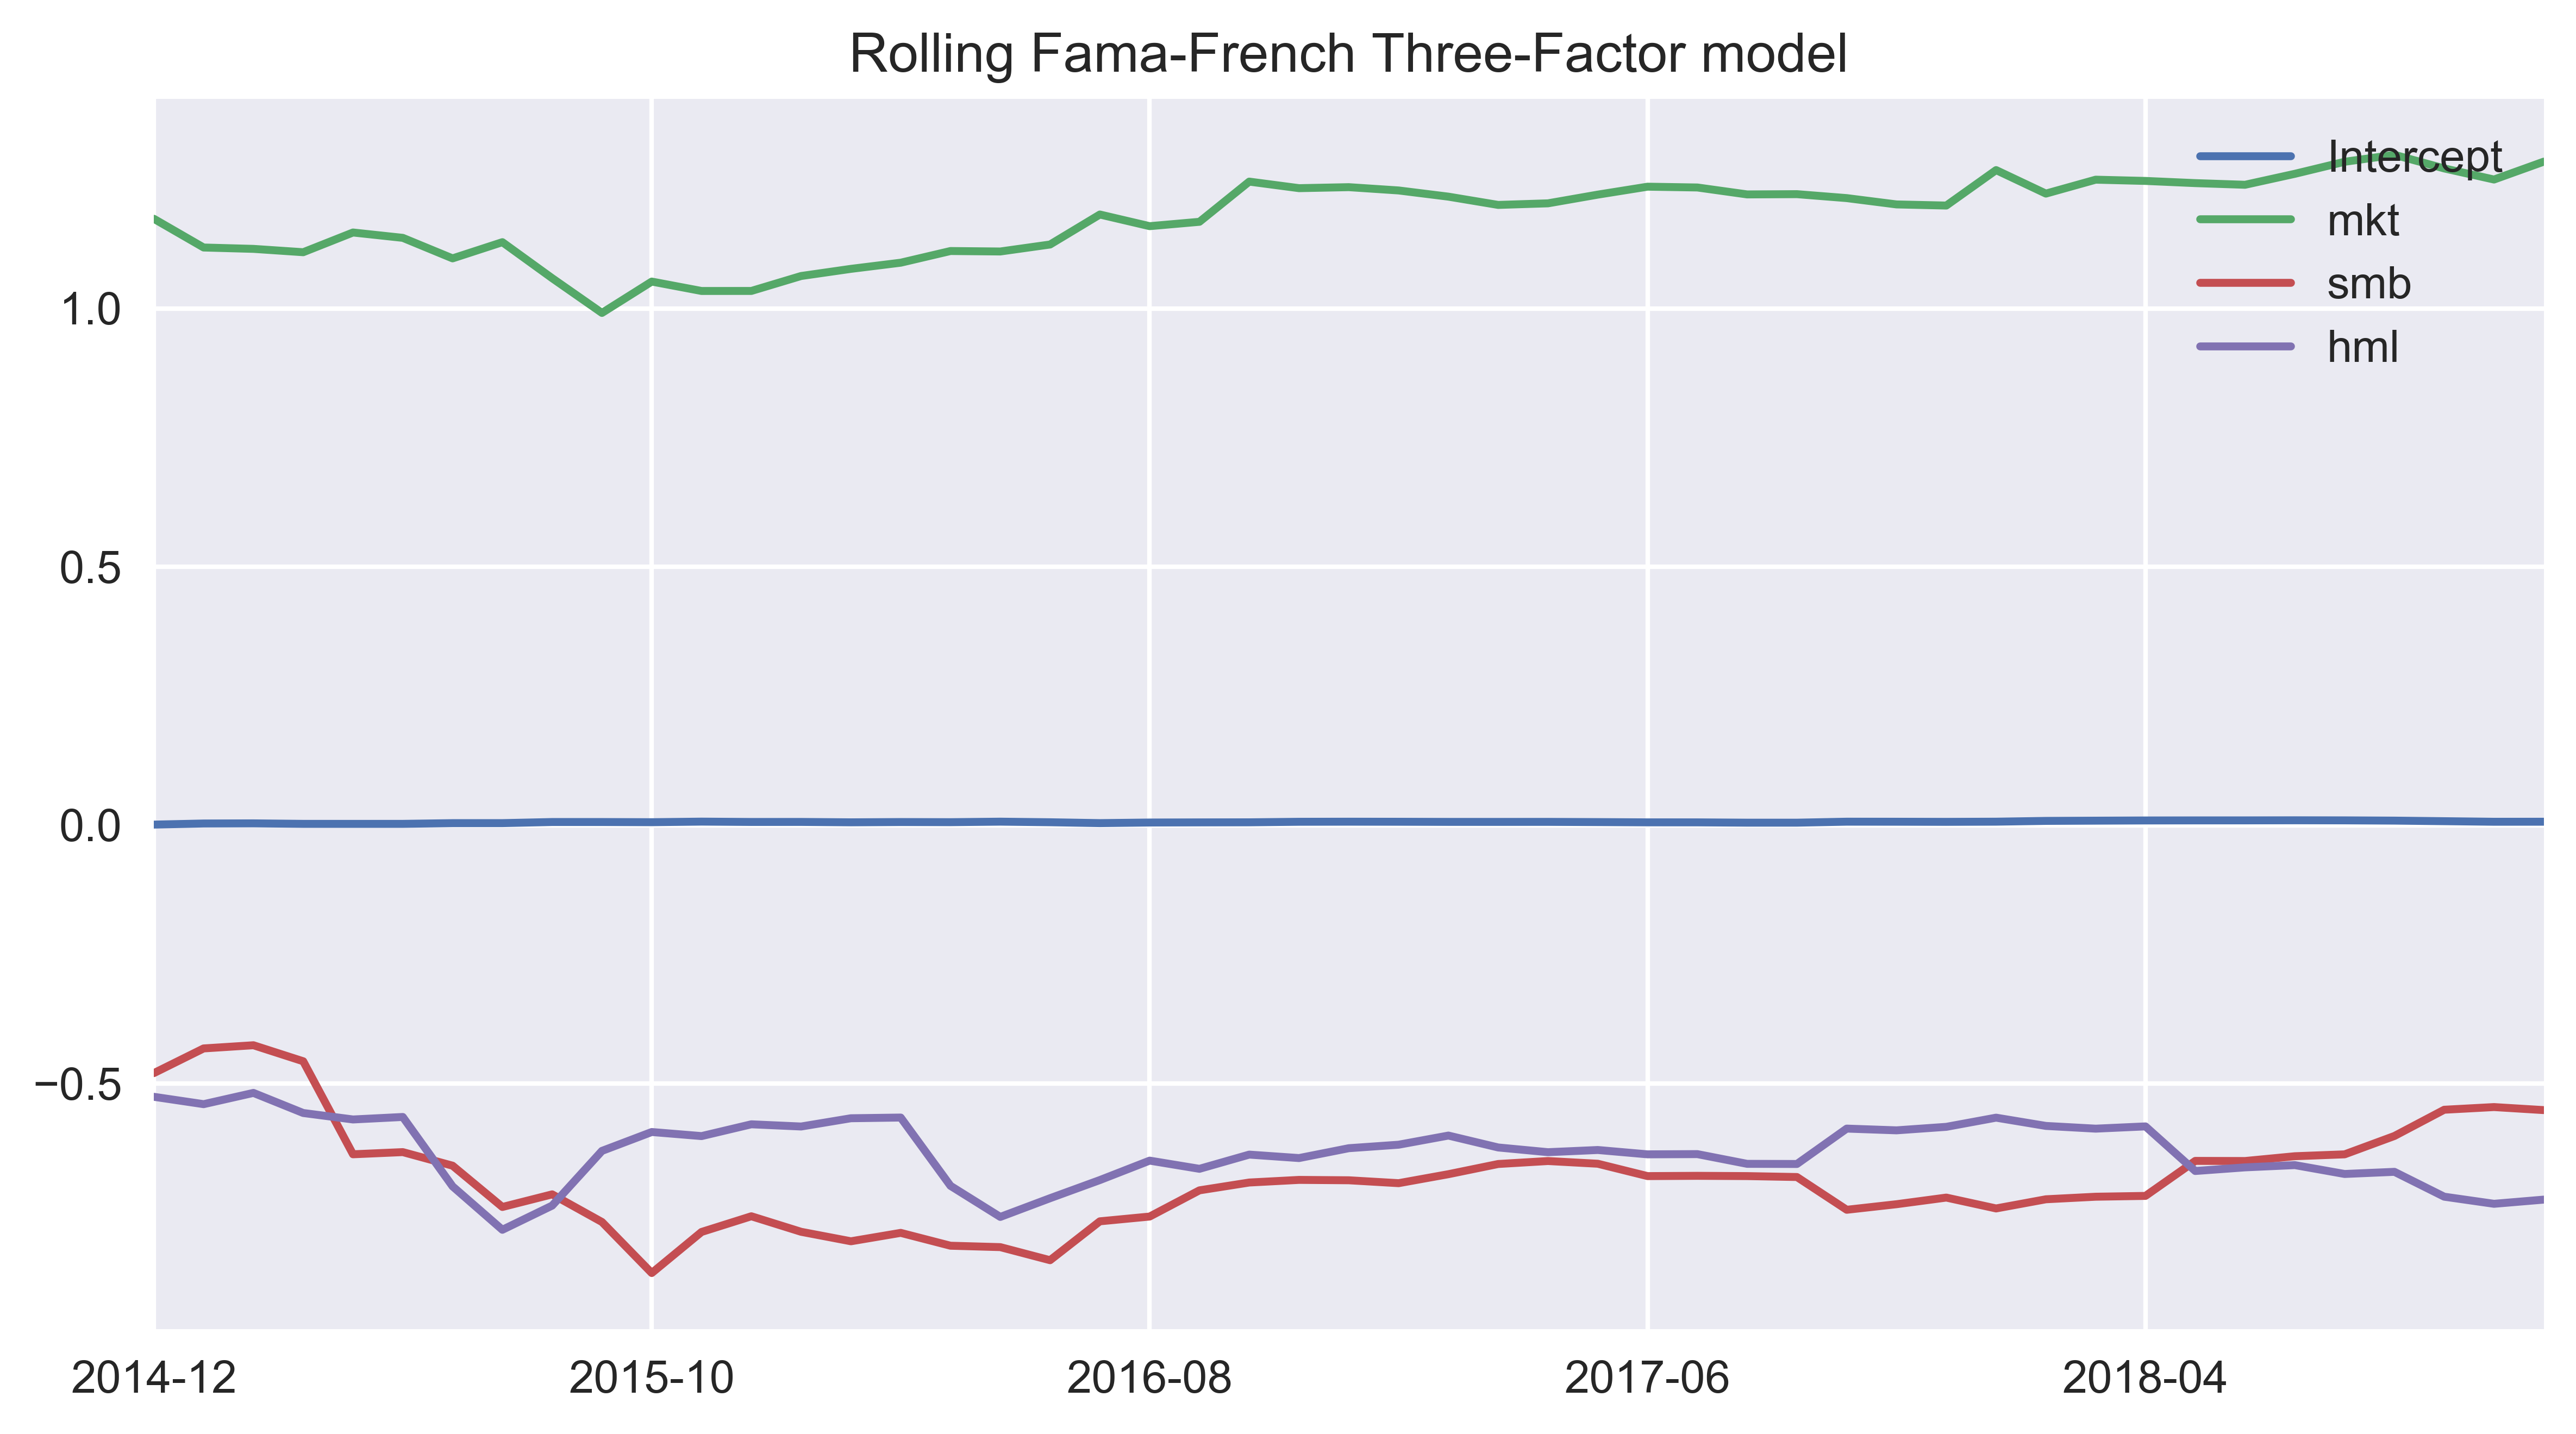

In [16]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

## Implementing the four- and five-factor models in Python

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

In [4]:
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

3. Download the risk factors from prof. French's website:

In [ ]:
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

4. Download the data of the risky asset from Yahoo Finance:

In [50]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


5. Calculate monthly returns:

In [45]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

6. Merge the datasets for the four-factor models:

In [46]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)

# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
four_factor_data.index = pd.to_datetime(four_factor_data.index, 
                                        format='%Y-%m')

# select period of interest
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0085,-0.0209,0.0,0.0170,-0.100554,-0.100554
2014-02-01,0.0465,0.0034,-0.0040,0.0,0.0207,0.009507,0.009507
2014-03-01,0.0043,-0.0189,0.0509,0.0,-0.0334,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0424,0.0114,0.0,-0.0386,-0.095847,-0.095847
2014-05-01,0.0206,-0.0186,-0.0027,0.0,0.0115,0.027686,0.027686


7. Merge the datasets for the five-factor models:

In [47]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
five_factor_data.index = pd.to_datetime(five_factor_data.index, 
                                        format='%Y-%m')

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01,-0.0332,0.0057,-0.0209,-0.0399,-0.0140,0.0,-0.100554,-0.100554
2014-02-01,0.0465,0.0015,-0.0040,-0.0026,-0.0041,0.0,0.009507,0.009507
2014-03-01,0.0043,-0.0117,0.0509,0.0216,0.0190,0.0,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0415,0.0114,0.0348,0.0107,0.0,-0.095847,-0.095847
2014-05-01,0.0206,-0.0189,-0.0027,0.0010,-0.0108,0.0,0.027686,0.027686


8. Estimate the four-factor model:

In [48]:
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     16.77
Date:                Sun, 19 Jan 2020   Prob (F-statistic):           4.82e-09
Time:                        21:31:16   Log-Likelihood:                 86.244
No. Observations:                  60   AIC:                            -162.5
Df Residuals:                      55   BIC:                            -152.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0094      0.008      1.164      0.2

9. Estimate the five-factor model:

In [49]:
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     15.85
Date:                Sun, 19 Jan 2020   Prob (F-statistic):           1.38e-09
Time:                        21:31:18   Log-Likelihood:                 89.416
No. Observations:                  60   AIC:                            -166.8
Df Residuals:                      54   BIC:                            -154.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0101      0.008      1.308      0.1